<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [1]:
# # # Google Colab
# !pip install keras_cv

In [2]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [4]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [5]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [6]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Feature Engineering 

<div>

In [7]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/valid_df.pkl", "rb") as f:
     valid_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

In [8]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [9]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

2025-04-22 22:17:16.197160: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-22 22:17:16.197194: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-22 22:17:16.197197: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-22 22:17:16.197213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 22:17:16.197227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<div class="alert alert-block alert-success">

# **3.** Models

<div>

## ResNet50

### Set-up

In [7]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [8]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=minority_class,
    augment='mixup',
    oversampling=True,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

NameError: name 'preprocess' is not defined

### Original

In [35]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 70
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [36]:
input_img = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [39]:
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="final_train_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
     lr_callback]


In [40]:
# Run the experiment
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=70)

No checkpoint found, starting from scratch.
Epoch 1/70


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_574']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.0140 - auc: 0.5414 - f1_score: 0.0073 - loss: 6.7492

2025-04-20 14:35:36.040338: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


350/350 ━━━━━━━━━━━━━━━━━━━━ 161s 437ms/step - accuracy: 0.0140 - auc: 0.5415 - f1_score: 0.0074 - loss: 6.7489 - val_accuracy: 0.1669 - val_auc: 0.7457 - val_f1_score: 0.0399 - val_loss: 4.5669 - learning_rate: 9.6764e-05
Epoch 2/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 143s 407ms/step - accuracy: 0.0703 - auc: 0.6464 - f1_score: 0.0293 - loss: 5.9851 - val_accuracy: 0.2582 - val_auc: 0.8372 - val_f1_score: 0.0916 - val_loss: 3.8400 - learning_rate: 9.3633e-05
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 394ms/step - accuracy: 0.1272 - auc: 0.7222 - f1_score: 0.0670 - loss: 5.0820 - val_accuracy: 0.3127 - val_auc: 0.8853 - val_f1_score: 0.1589 - val_loss: 3.3831 - learning_rate: 9.0603e-05
Epoch 4/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 141s 402ms/step - accuracy: 0.1843 - auc: 0.7874 - f1_score: 0.1118 - loss: 4.3888 - val_accuracy: 0.3662 - val_auc: 0.9102 - val_f1_score: 0.2266 - val_loss: 3.0586 - learning_rate: 8.7671e-05
Epoch 5/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 134s 383ms/step - accuracy: 0.2360 

In [41]:
df_history = pd.DataFrame(history.history)
df_history.to_csv('resnet50_final_history.csv', index=False)

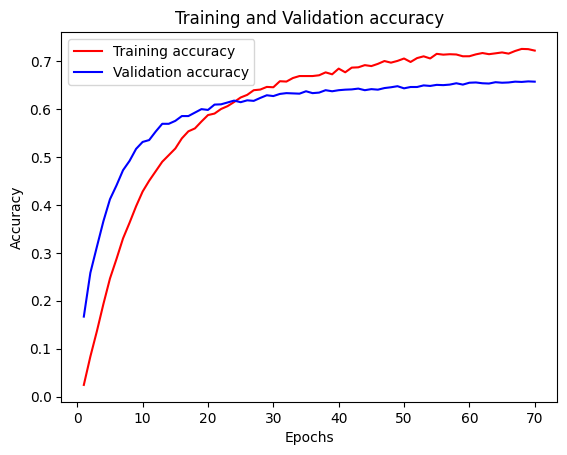

In [42]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=70, train_acc=acc_train, val_acc=acc_val)

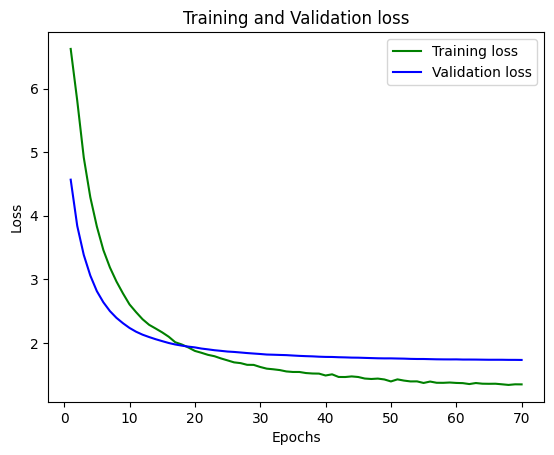

In [43]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=70, train_loss=loss_train, val_loss=loss_val)

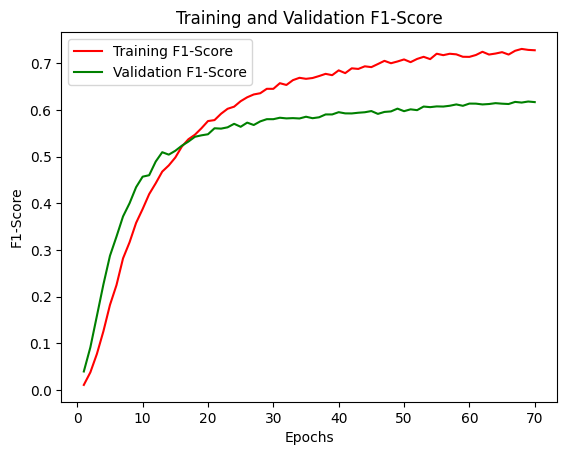

In [44]:
x_axis = range(1,70+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [45]:
experiment.model.save("final_training_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70.keras")

### Train until optimal point

In [12]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 4.5409e-05
n_epochs = 25
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [13]:
input_img = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

In [14]:
experiment_final = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="train2_until_optimal_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
     lr_callback]

In [15]:
history_final = experiment_final.run_experiment(callbacks=callbacks_additional, epochs=25)

No checkpoint found, starting from scratch.
Epoch 1/25


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-04-22 10:34:27.642735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


350/350 ━━━━━━━━━━━━━━━━━━━━ 126s 344ms/step - accuracy: 0.0151 - auc: 0.5467 - f1_score: 0.0076 - loss: 6.7604 - val_accuracy: 0.1614 - val_auc: 0.7316 - val_f1_score: 0.0369 - val_loss: 4.6475 - learning_rate: 9.6891e-05
Epoch 2/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 394ms/step - accuracy: 0.0695 - auc: 0.6406 - f1_score: 0.0277 - loss: 5.9392 - val_accuracy: 0.2309 - val_auc: 0.8317 - val_f1_score: 0.0772 - val_loss: 3.9207 - learning_rate: 9.3880e-05
Epoch 3/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 140s 399ms/step - accuracy: 0.1304 - auc: 0.7310 - f1_score: 0.0671 - loss: 4.9320 - val_accuracy: 0.2938 - val_auc: 0.8916 - val_f1_score: 0.1587 - val_loss: 3.4174 - learning_rate: 9.0961e-05
Epoch 4/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 151s 432ms/step - accuracy: 0.2023 - auc: 0.8105 - f1_score: 0.1273 - loss: 4.1428 - val_accuracy: 0.3584 - val_auc: 0.9183 - val_f1_score: 0.2296 - val_loss: 3.0582 - learning_rate: 8.8134e-05
Epoch 5/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 150s 429ms/step - accuracy: 0.2581 

In [16]:
df_history_final = pd.DataFrame(history_final.history)
df_history_final.to_csv('resnet50_final_train_history.csv', index=False)

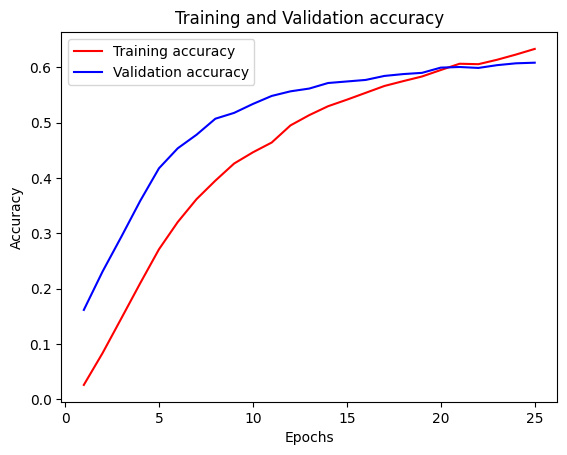

In [17]:
acc_train_final = history_final.history['accuracy']
acc_val_final = history_final.history['val_accuracy']
plot_model_acc(num_epochs=25, train_acc=acc_train_final, val_acc=acc_val_final)

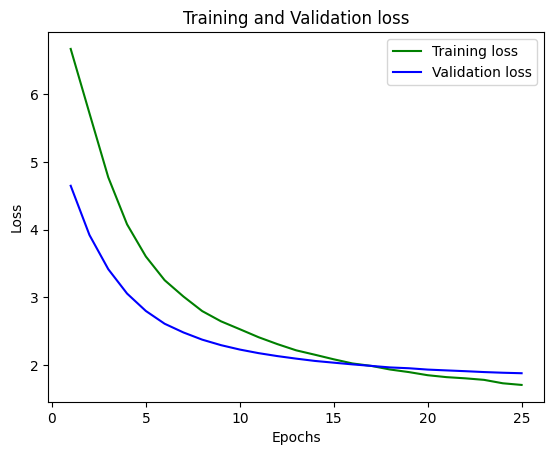

In [18]:
loss_train_final = history_final.history['loss']
loss_val_final = history_final.history['val_loss']
plot_model_loss(num_epochs=25, train_loss=loss_train_final, val_loss=loss_val_final)

In [20]:
experiment_final.model.save("train2_until_optimal_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

### Fine-tune

In [39]:
# Load datasets
train_ds_ft, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment=None,
    oversampling=False,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds_ft, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


References: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pt-br

"When fine-tuning a pre-trained model that contains BatchNormalization layers, it is usually a good idea to keep them frozen (i.e., set layer.trainable = False), to avoid corrupting the running statistics that the layers have learned."


In [43]:
model = load_model("train2_until_optimal_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras", compile=False)

In [44]:
len(model.layers)

179

In [45]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 5e-6
final_lr = 1e-7
n_epochs = 30
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [ ]:
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

for layer in base_model.layers[145:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [47]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-6),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

fine_tune_epochs = 30
total_epochs = 30 + fine_tune_epochs 


In [48]:
history_finetune = model.fit(
    train_ds_ft,
    epochs=total_epochs,
    initial_epoch=30,
    validation_data=val_ds_ft,
    callbacks=[early_stop, lr_callback],
)


Epoch 31/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 111s 378ms/step - accuracy: 0.6248 - auc: 0.9752 - f1_score: 0.5839 - loss: 1.6931 - val_accuracy: 0.6093 - val_auc: 0.9652 - val_f1_score: 0.5578 - val_loss: 1.8816 - learning_rate: 8.7774e-07
Epoch 32/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 108s 410ms/step - accuracy: 0.6333 - auc: 0.9749 - f1_score: 0.5832 - loss: 1.7114 - val_accuracy: 0.6088 - val_auc: 0.9652 - val_f1_score: 0.5587 - val_loss: 1.8806 - learning_rate: 7.7043e-07
Epoch 33/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 118s 450ms/step - accuracy: 0.6208 - auc: 0.9737 - f1_score: 0.5766 - loss: 1.7174 - val_accuracy: 0.6093 - val_auc: 0.9652 - val_f1_score: 0.5586 - val_loss: 1.8798 - learning_rate: 6.7624e-07
Epoch 34/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 112s 427ms/step - accuracy: 0.6297 - auc: 0.9744 - f1_score: 0.5842 - loss: 1.7041 - val_accuracy: 0.6093 - val_auc: 0.9652 - val_f1_score: 0.5580 - val_loss: 1.8793 - learning_rate: 5.9357e-07
Epoch 35/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step - a

It's already overfiting. Lets do hyperband tuner in this fine tuning phase.

### Fine tune with hyperband tuner

In [14]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [15]:
model_ft = load_model("fr_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70.keras", compile=False)

In [16]:
len(model_ft.layers)

179

In [17]:
import keras_tuner as kt

In [18]:
def model_builder(hp):
    number_layers_unfreeze = hp.Int('number_layers_unfreeze', min_value = 1, max_value=15, step=1)

    trainable = False
    for layer in model_ft.layers:
        layer.trainable = trainable

    if number_layers_unfreeze>0:
        for layer in model_ft.layers[-number_layers_unfreeze:]:
            layer.trainable = True

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-6, 1e-7])

    model_ft.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=metrics)

    return model_ft

In [19]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective=kt.Objective("val_loss", direction="min"),  # ou "val_f1_score", direction="max"
    max_epochs=45,
    factor=3,
    hyperband_iterations=1,
    seed=42,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    directory='project/project',
    project_name='fr19_hyperband_finetune_resnet50_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler_70'
)

In [20]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)]

In [21]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Trial 30 Complete [04h 51m 58s]
val_loss: 1.7993829250335693

Best val_loss So Far: 1.7790106534957886
Total elapsed time: 17h 36m 53s

Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
12                |4                 |number_layers_unfreeze
1e-06             |1e-07             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: 

**RUN 1**: The first run of the hyperband tuner showed that a small number of layers to unfreeze + small learning rates are better, so the maximum number of layers to unfreeze will be 15 and we will try a smaller value of learning rate

## EfficientNet

### Base line (without preprocessing and without regularization)

In [29]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [30]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [31]:
# Load datasets
train_ds_baseline1, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment=None,
    oversampling=False,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds_baseline1, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [32]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(202, activation='softmax')(x)

model_baseline1 = models.Model(inputs=base_model.input, outputs=x)

model_baseline1.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

In [38]:
experiment_baseline1 = Experiment(
    model=model_baseline1,
    train_ds=train_ds_baseline1,
    val_ds=val_ds_baseline1,
    experiment_name="Efficient_net_baseline1",
    batch_size=32,
    image_size=(224, 224)
)

In [39]:
history_baseline1 = experiment_baseline1.run_experiment(callbacks=None, epochs=25)

No checkpoint found, starting from scratch.
Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 360ms/step - acc: 0.3534 - auc: 0.9424 - f1_score: 0.2043 - loss: 3.2932 - val_acc: 0.3968 - val_auc: 0.9478 - val_f1_score: 0.2444 - val_loss: 2.9208
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 135s 510ms/step - acc: 0.4381 - auc: 0.9638 - f1_score: 0.2921 - loss: 2.6855 - val_acc: 0.4674 - val_auc: 0.9595 - val_f1_score: 0.3188 - val_loss: 2.4960
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 101s 381ms/step - acc: 0.5238 - auc: 0.9739 - f1_score: 0.3923 - loss: 2.2544 - val_acc: 0.5153 - val_auc: 0.9692 - val_f1_score: 0.3788 - val_loss: 2.1885
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 98s 372ms/step - acc: 0.5865 - auc: 0.9825 - f1_score: 0.4751 - loss: 1.9269 - val_acc: 0.5543 - val_auc: 0.9727 - val_f1_score: 0.4284 - val_loss: 1.9627
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 141s 535ms/step - acc: 0.6333 - auc: 0.9858 - f1_score: 0.5385 - loss: 1.6840 - val_acc: 0.5860 - val_auc: 0.9758 - val_f1_score: 0.48

In [50]:
df_history_baseline1 = pd.DataFrame(history_baseline1.history)
df_history_baseline1.to_csv('efficient_net_baseline1_history.csv', index=False)

### Base line (without preprocessing and with regularization)

In [40]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [48]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [42]:
# Load datasets
train_ds_baseline2, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment=None,
    oversampling=False,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds_baseline2, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [43]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x) # regularization parameter
x = layers.Dropout(0.5)(x) # regularization layer
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

baseline_model2 = models.Model(inputs=base_model.input, outputs=x)

baseline_model2.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01), # regularization parameter
    metrics=metrics
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

In [49]:
experiment_baseline2 = Experiment(
    model=baseline_model2,
    train_ds=train_ds_baseline2,
    val_ds=val_ds_baseline2,
    experiment_name="Efficient_net_baseline2",
    batch_size=32,
    image_size=(224, 224)
)

history_baseline2 = experiment_baseline2.run_experiment(callbacks=callbacks, epochs=50)

Resuming training from epoch 11
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 114s 404ms/step - acc: 0.5090 - auc: 0.9652 - f1_score: 0.3633 - loss: 2.2868 - val_acc: 0.5492 - val_auc: 0.9708 - val_f1_score: 0.3895 - val_loss: 2.1670 - learning_rate: 7.5858e-05
Epoch 13/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 85s 322ms/step - acc: 0.5210 - auc: 0.9692 - f1_score: 0.3878 - loss: 2.2065 - val_acc: 0.5576 - val_auc: 0.9716 - val_f1_score: 0.4066 - val_loss: 2.1109 - learning_rate: 7.4131e-05
Epoch 14/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 366ms/step - acc: 0.5412 - auc: 0.9694 - f1_score: 0.4073 - loss: 2.1418 - val_acc: 0.5704 - val_auc: 0.9731 - val_f1_score: 0.4249 - val_loss: 2.0598 - learning_rate: 7.2444e-05
Epoch 15/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step - acc: 0.5484 - auc: 0.9724 - f1_score: 0.4199 - loss: 2.0935 - val_acc: 0.5748 - val_auc: 0.9739 - val_f1_score: 0.4367 - val_loss: 2.0137 - learning_rate: 7.0795e-05
Epoch 16/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 87s 327ms/step - acc: 0.5592 -

In [51]:
df_history_baseline2 = pd.DataFrame(history_baseline2.history)
df_history_baseline2.to_csv('efficient_net_baseline2_history.csv', index=False)

### Set-up

In [10]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [11]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=minority_class,
    augment='mixup',
    oversampling=True,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


### Head Train

In [68]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)



In [69]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [70]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    lr_callback
]

In [71]:
experiment_en = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="efficient_net_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)


In [72]:
history_en = experiment_en.run_experiment(callbacks=callbacks_additional, epochs=50)

No checkpoint found, starting from scratch.
Epoch 1/50


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2153']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 178s 468ms/step - acc: 0.0219 - auc: 0.5791 - f1_score: 0.0109 - loss: 5.3607 - val_acc: 0.2204 - val_auc: 0.8191 - val_f1_score: 0.0810 - val_loss: 4.5216 - learning_rate: 9.6891e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 130s 370ms/step - acc: 0.1629 - auc: 0.7866 - f1_score: 0.0703 - loss: 4.5532 - val_acc: 0.3122 - val_auc: 0.9071 - val_f1_score: 0.1592 - val_loss: 3.8685 - learning_rate: 9.3880e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 145s 413ms/step - acc: 0.2452 - auc: 0.8742 - f1_score: 0.1391 - loss: 3.9729 - val_acc: 0.3639 - val_auc: 0.9406 - val_f1_score: 0.2160 - val_loss: 3.4068 - learning_rate: 9.0961e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 332ms/step - acc: 0.3084 - auc: 0.9111 - f1_score: 0.1979 - loss: 3.5632 - val_acc: 0.4118 - val_auc: 0.9576 - val_f1_score: 0.2705 - val_loss: 3.0579 - learning_rate: 8.8134e-05
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 129s 367ms/step - acc: 0.3605 - auc: 0.9337 - f1_score: 0.2553 - loss: 3.21

In [74]:
df_history_en = pd.DataFrame(history_en.history)
df_history_en.to_csv('efficient_net_final_train_history.csv', index=False)

In [73]:
model.save("efficient_net_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

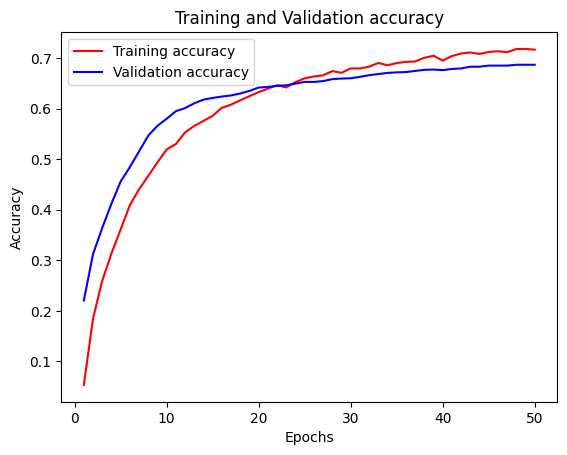

In [78]:
acc_train_en = history_en.history['acc']
acc_val_en = history_en.history['val_acc']
plot_model_acc(num_epochs=50, train_acc=acc_train_en, val_acc=acc_val_en)

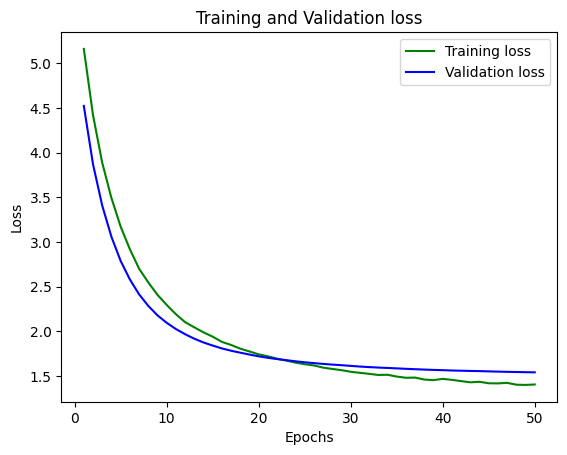

In [80]:
loss_train_en = history_en.history['loss']
loss_val_en = history_en.history['val_loss']
plot_model_loss(num_epochs=50, train_loss=loss_train_en, val_loss=loss_val_en)

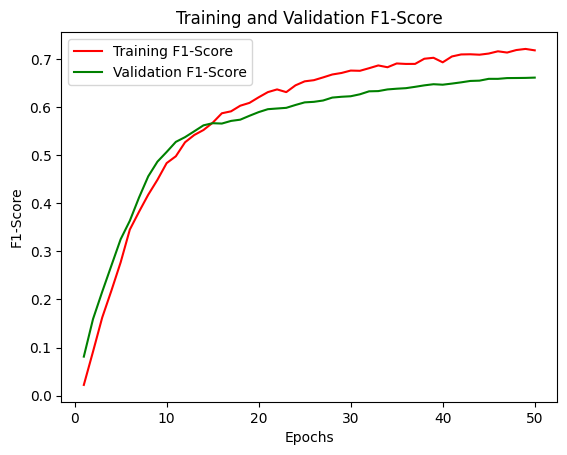

In [81]:
x_axis = range(1,50+1)
plt.plot(x_axis, history_en.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history_en.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

### Fine-tune

In [16]:
base_model_ft_en = load_model("efficient_net_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras", compile=False)

In [17]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-5
final_lr = 1e-6
n_epochs = 100
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)



In [18]:
progressive_unfreeze = ProgressiveUnfreeze(base_model_ft_en)

base_model_ft_en.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [19]:
experiment_ft = Experiment(
    model=base_model_ft_en,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="efficientnet_finetune_c",
    batch_size=32,
    image_size=(224, 224),
    save_model=True
)

history_ft_en = experiment_ft.run_experiment(
    epochs=100,
    callbacks=[progressive_unfreeze, lr_callback]
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - acc: 0.7133 - auc: 0.9891 - f1_score: 0.6941 - loss: 1.4267Epoch 0: Layer now unfrozen 241 (dense_7)
350/350 ━━━━━━━━━━━━━━━━━━━━ 113s 306ms/step - acc: 0.7133 - auc: 0.9891 - f1_score: 0.6942 - loss: 1.4267 - val_acc: 0.6867 - val_auc: 0.9801 - val_f1_score: 0.6611 - val_loss: 1.5418 - learning_rate: 9.7724e-06
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 296ms/step - acc: 0.7269 - auc: 0.9894 - f1_score: 0.7065 - loss: 1.4045 - val_acc: 0.6878 - val_auc: 0.9801 - val_f1_score: 0.6624 - val_loss: 1.5405 - learning_rate: 9.5499e-06
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - acc: 0.7130 - auc: 0.9893 - f1_score: 0.6895 - loss: 1.4263Epoch 2: Layer now unfrozen 240 (dropout_3)
350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 286ms/step - acc: 0.7130 - auc: 0.9893 - f1_score: 0.6896 - loss: 1.4262 - val_acc: 0.6889 - val_auc: 0.9799 - val_f1_score: 0.6628 - val_loss: 1.5397 - learning_rate

In [20]:
base_model_ft_en.save("efficient_net_finetuned_final.keras")

In [21]:
test_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/test",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 1798 files belonging to 202 classes.


In [23]:
base_model_ft_en.evaluate(test_ds)

57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - acc: 0.7113 - auc: 0.9231 - f1_score: 0.3195 - loss: 1.3660


[1.470661997795105, 0.7018910050392151, 0.964812159538269, 0.6690705418586731]

In [28]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

y_true = []
y_pred = []

for batch_x, batch_y in test_ds:
    preds = base_model_ft_en.predict(batch_x)
    y_true.append(np.argmax(batch_y.numpy(), axis=1))
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(y_true, y_pred, digits=4))

print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))
print("Accuracy :", accuracy_score(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-04-23 10:24:26.849485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: Und

In [52]:
history_ft_en = pd.DataFrame(history_ft_en.history)
history_ft_en.to_csv('efficient_net_final_finetune_history.csv', index=False)

## VGG16

### Set-up

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 

In [16]:
# Load datasets
train_ds_vgg16, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment='mixup',
    shuffle=True,
    oversampling=True,
    preprocessing_function=preprocess_input)

val_ds_vgg16, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    shuffle=False,
    augment=None,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [17]:
verbose = 1

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

### Running the first try

In [10]:
input_img = Input(shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

In [11]:
experiment2 = Experiment(
    model=model,
    train_ds= train_ds_vgg16,
    val_ds=val_ds_vgg16,
    experiment_name="final_vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]


In [13]:
history2 = experiment2.run_experiment(callbacks=callbacks_additional, epochs=100)

Resuming training from epoch 17
Epoch 18/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 192s 545ms/step - accuracy: 0.2843 - auc: 0.7558 - f1_score: 0.1983 - loss: 6.7135 - val_accuracy: 0.4240 - val_auc: 0.8544 - val_f1_score: 0.3164 - val_loss: 3.7047 - learning_rate: 1.0000e-04
Epoch 19/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 190s 541ms/step - accuracy: 0.2953 - auc: 0.7654 - f1_score: 0.2105 - loss: 6.4010 - val_accuracy: 0.4335 - val_auc: 0.8576 - val_f1_score: 0.3199 - val_loss: 3.6488 - learning_rate: 1.0000e-04
Epoch 20/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 186s 531ms/step - accuracy: 0.3051 - auc: 0.7708 - f1_score: 0.2216 - loss: 6.1377 - val_accuracy: 0.4474 - val_auc: 0.8644 - val_f1_score: 0.3427 - val_loss: 3.4787 - learning_rate: 1.0000e-04
Epoch 21/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 187s 533ms/step - accuracy: 0.3156 - auc: 0.7770 - f1_score: 0.2383 - loss: 5.8657 - val_accuracy: 0.4585 - val_auc: 0.8690 - val_f1_score: 0.3568 - val_loss: 3.3691 - learning_rate: 1.0000e-04
Epoch 22/100
350/350 ━━━

In [14]:
experiment2.model.save("final_vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

In [15]:
df_history2 = pd.DataFrame(history2.history)
df_history2.to_csv('vgg_history.csv', index=False)

In [ ]:
acc_train2 = history2.history['accuracy']
acc_val2 = history2.history['val_accuracy']

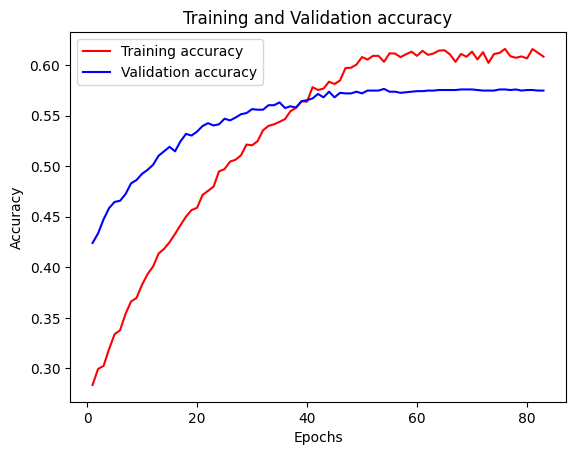

In [21]:
plot_model_acc(num_epochs=83, train_acc=acc_train2, val_acc=acc_val2)

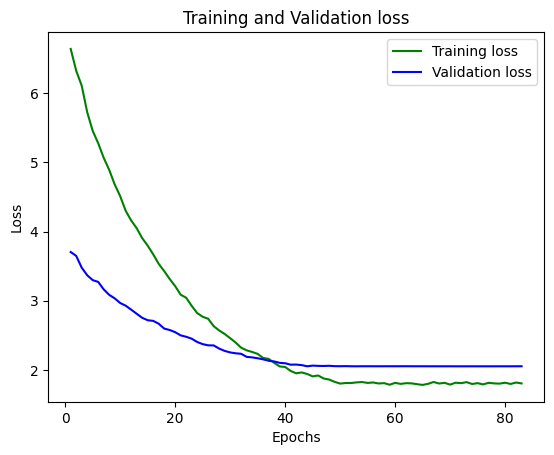

In [22]:
loss_train2 = history2.history['loss']
loss_val2 = history2.history['val_loss']
plot_model_loss(num_epochs=83, train_loss=loss_train2, val_loss=loss_val2)

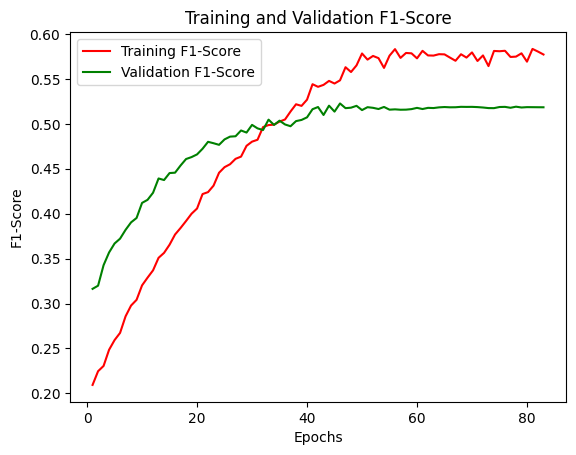

In [23]:
x_axis = range(1,83+1)
plt.plot(x_axis, history2.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history2.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

### Training until overfit

In [18]:
input_img = Input(shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

In [19]:
experiment3 = Experiment(
    model=model,
    train_ds= train_ds_vgg16,
    val_ds=val_ds_vgg16,
    experiment_name="final_train_until_optimal_vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)

# Callbacks to reduce overfitting
callbacks_additional = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,           # Reduce LR if no improvement after 2 epochs
        min_lr=1e-6,
        verbose=1
    )]


In [20]:
history3 = experiment3.run_experiment(callbacks=callbacks_additional, epochs=50)

No checkpoint found, starting from scratch.
Epoch 1/50


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_358']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 221s 625ms/step - accuracy: 0.0085 - auc: 0.5109 - f1_score: 0.0051 - loss: 19.4201 - val_accuracy: 0.0751 - val_auc: 0.5975 - val_f1_score: 0.0175 - val_loss: 10.2145 - learning_rate: 1.0000e-04
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - accuracy: 0.0275 - auc: 0.5339 - f1_score: 0.0114 - loss: 18.6418 - val_accuracy: 0.1369 - val_auc: 0.6426 - val_f1_score: 0.0301 - val_loss: 8.9376 - learning_rate: 1.0000e-04
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 205s 586ms/step - accuracy: 0.0492 - auc: 0.5530 - f1_score: 0.0214 - loss: 18.3625 - val_accuracy: 0.1803 - val_auc: 0.6725 - val_f1_score: 0.0395 - val_loss: 8.2892 - learning_rate: 1.0000e-04
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 207s 591ms/step - accuracy: 0.0598 - auc: 0.5640 - f1_score: 0.0226 - loss: 17.4769 - val_accuracy: 0.2042 - val_auc: 0.6972 - val_f1_score: 0.0513 - val_loss: 7.7543 - learning_rate: 1.0000e-04
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 207s 593ms/step - accuracy: 0.

In [21]:
experiment3.model.save("final_train_until_optimal_vgg16_with_preprocessing_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

In [22]:
df_history3 = pd.DataFrame(history3.history)
df_history3.to_csv('vgg_history_train_until_opt.csv', index=False)

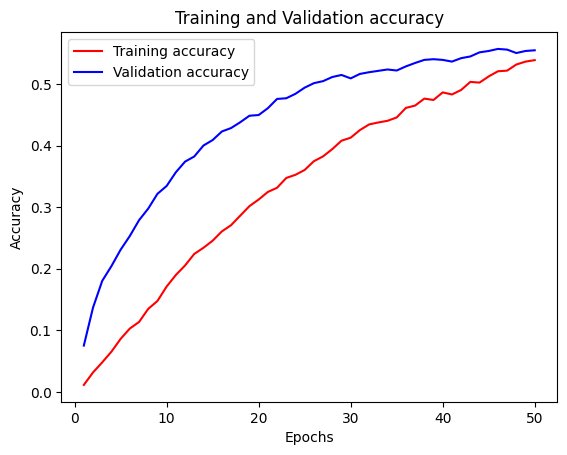

In [23]:
acc_train3 = history3.history['accuracy']
acc_val3 = history3.history['val_accuracy']
plot_model_acc(num_epochs=50, train_acc=acc_train3, val_acc=acc_val3)

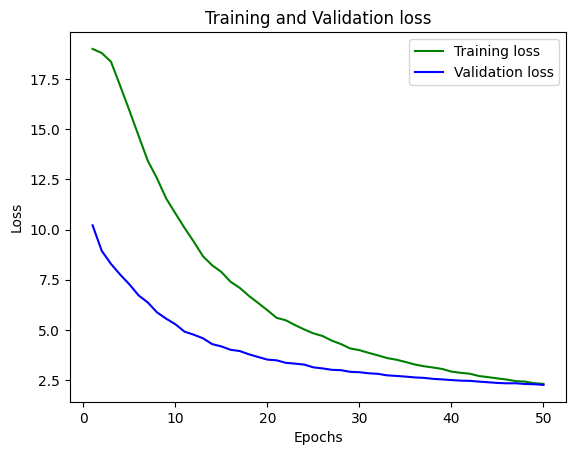

In [24]:
loss_train3 = history3.history['loss']
loss_val3 = history3.history['val_loss']
plot_model_loss(num_epochs=50, train_loss=loss_train3, val_loss=loss_val3)

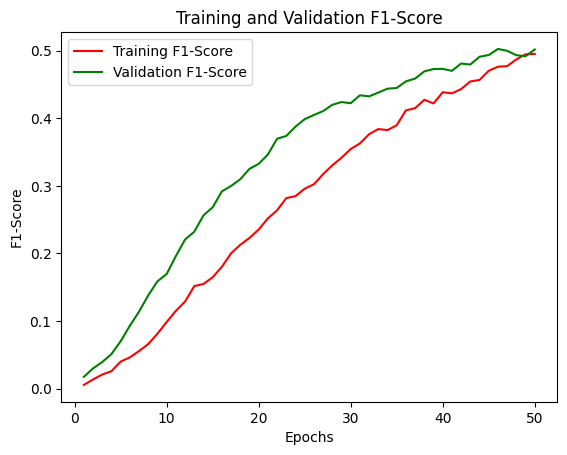

In [25]:
x_axis = range(1,50+1)
plt.plot(x_axis, history3.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history3.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

## Comparisons

### Set-up

In [92]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt


In [59]:
files = {
    "VGG16": "vgg_history_train_until_opt.csv",
    "ResNet50": "resnet50_final_train_history.csv",
    "EfficientNet Baseline 1": "efficient_net_baseline1_history.csv",
    "EfficientNet Baseline 2": "efficient_net_baseline2_history.csv",
    "EfficientNet Final": "efficient_net_final_train_history.csv",
    "EfficientNet Fine-Tuned": "efficient_net_final_finetune_history.csv"
}


In [ ]:
def load_history(path):
    df = pd.read_csv(path)
    if 'acc' in df.columns:
        df = df.rename(columns={'acc': 'accuracy'})
    if 'val_acc' in df.columns:
        df = df.rename(columns={'val_acc': 'val_accuracy'})
    return df


In [80]:
histories = {label: load_history(path) for label, path in files.items()}

summary_list = []
for label, df in histories.items():
    last_epoch = df.iloc[-1]
    # Para cada métrica, tenta pegar 'accuracy' e 'f1_score'
    summary_list.append({
        "Model": label,
        "Train Set Accuracy": last_epoch.get("accuracy", last_epoch.get("accuracy", None)),
        "Validation Set Accuracy": last_epoch.get("val_accuracy", last_epoch.get("val_accuracy", None)),
        "Train Set F1-Score": last_epoch.get("f1_score", last_epoch.get("f1_score", None)),
        "Validation Set F1-Score": last_epoch.get("val_f1_score", last_epoch.get("val_f1_score", None)),
        "Train Set Loss": last_epoch.get("loss", last_epoch.get("loss", None)),
        "Validation Set Loss": last_epoch.get("val_loss", last_epoch.get("val_loss", None))
    })

summary_df = pd.DataFrame(summary_list)
summary_df = summary_df.set_index("Model")
summary_df = summary_df.sort_values(by="Validation Set F1-Score", ascending=False)


### Final Summary

In [87]:
summary_df = summary_df.sort_values(by="Validation Set F1-Score", ascending=False)

In [ ]:
summary_df

,Train Set Accuracy,Validation Set Accuracy,Train Set F1-Score,Validation Set F1-Score,Train Set Loss,Validation Set Loss
Model,,,,,,
EfficientNet Fine-Tuned,0.733482,0.700612,0.736858,0.677013,1.344867,1.513090
EfficientNet Baseline 1,0.920720,0.708959,0.923846,0.667322,0.414008,1.149756
EfficientNet Final,0.716607,0.686700,0.717598,0.660923,1.406863,1.542795
EfficientNet Baseline 2,0.706366,0.657763,0.666257,0.591676,1.428393,1.591309
ResNet50,0.633125,0.608236,0.625082,0.556639,1.710753,1.883143
VGG16,0.538839,0.554814,0.494909,0.501549,2.305127,2.251417


### Plots

In [122]:
plt.rcParams['font.family'] = 'Aptos'

<Figure size 640x800 with 0 Axes>

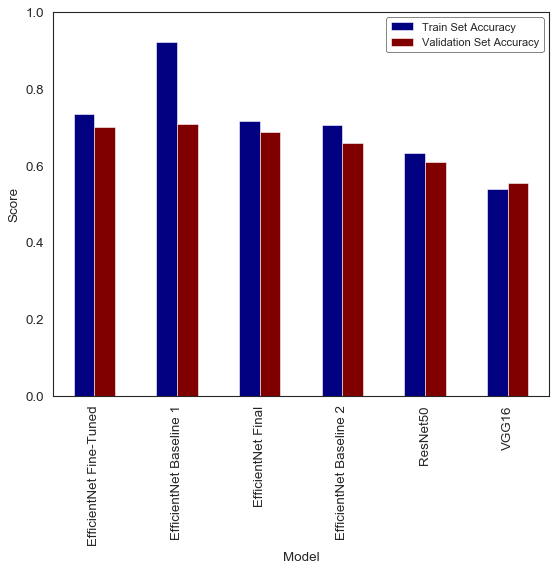

In [136]:
sns.set_style("white")
plt.figure(figsize=(8, 10))
ax = summary_df[['Train Set Accuracy', 'Validation Set Accuracy']].plot(kind='bar', color=['navy', 'maroon'], legend=False)
ax.legend(loc='upper right', fontsize=10)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()


<Figure size 640x800 with 0 Axes>

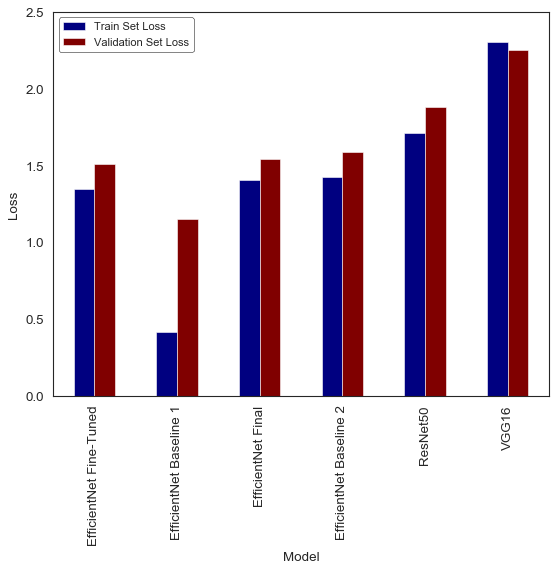

In [135]:
sns.set_style("white")
plt.figure(figsize=(8, 10))
ax = summary_df[['Train Set Loss', 'Validation Set Loss']].plot(kind='bar', color=['navy', 'maroon'], legend=False)
ax.legend(loc='upper left', fontsize=10)
plt.ylabel("Loss")
plt.ylim(0, 2.5)
plt.xticks(rotation=90)
plt.show()

<Figure size 640x800 with 0 Axes>

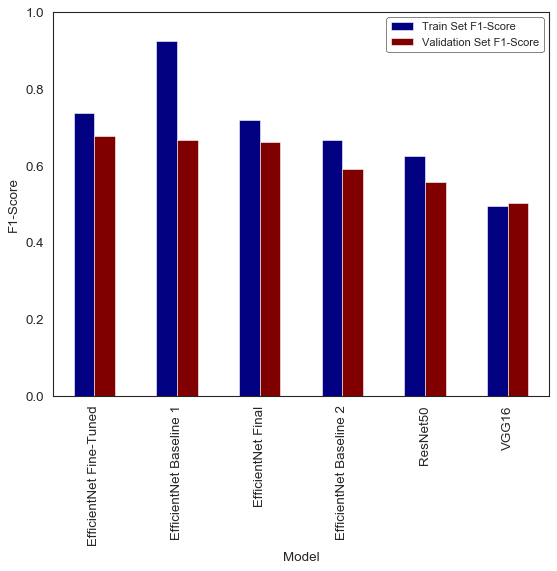

In [133]:
sns.set_style("white")
plt.figure(figsize=(8, 10))
ax = summary_df[['Train Set F1-Score', 'Validation Set F1-Score']].plot(kind='bar', color=['navy', 'maroon'], legend=False)
ax.legend(loc='upper right', fontsize=10)
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()